<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-Isaias-Hernandez/blob/main/Nov3-4/(comentado)proyecto_ml_mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esta es la versión comentada del proyecto con ligeras modificaciones al código. Se modificaron las paletas de colores de las gráficas, se añadió gráficas a la interpretación de los resultados (histogramas) y repeticiones a la obtención de parametros y convergencia. Los resultados del proyecto son los mismos al igual que la metodología.

# Proyecto Parcial - Implementación de inferencia bayesiana y cadenas de Markov

Por Isaías Hernández Lares

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

In [123]:
sns.set_palette("colorblind")
plt.style.use("ggplot")

______________________________________________
# Data set: Heart Failure Prediction Dataset
fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

"Las enfermedades cardiovasculares (ECV) son la principal causa de muerte a nivel mundial, cobrando aproximadamente 17.9 millones de vidas al año, lo que representa el 31% de todas las muertes en todo el mundo. Cuatro de cada 5 muertes por ECV se deben a ataques cardíacos y derrames cerebrales, y un tercio de estas muertes ocurren prematuramente en personas menores de 70 años. La insuficiencia cardíaca es un evento común causado por las ECV y este conjunto de datos contiene 11 características que se pueden utilizar para predecir una posible enfermedad cardíaca.

Las personas con enfermedades cardiovasculares o que tienen un alto riesgo cardiovascular (debido a la presencia de uno o más factores de riesgo como la hipertensión, la diabetes, la hiperlipidemia o una enfermedad ya establecida) necesitan detección temprana y manejo, en donde un modelo de aprendizaje automático puede ser de gran ayuda."

Attribute Information
* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
*HeartDisease: output class [1: heart disease, 0: Normal]

-----------------------------

Como objetivo se espera predecir a partir de los mediciones si el paciente cuenta con enfermedad cardiaca.


In [124]:
heart = pd.read_csv("/content/drive/MyDrive/ML2023/heart.csv")
numericos = ["Age",'RestingBP', 'Cholesterol', 'MaxHR', "Oldpeak"]
categorical = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]

In [125]:
heart

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


El Dataset cuenta con mediciones de valor 0 en columnas de "Cholesterol" y "Oldpeak". Para poder graficar sin que sean tomadas en cuenta y observar las relaciones que hay entre las variables las asignamos a nan.

In [126]:
heart.loc[heart.Oldpeak==0, "Oldpeak"] = np.nan
heart.loc[heart.Cholesterol==0, "Cholesterol"] = np.nan

Se utiliza un pairplot para observar el comportamiento de las variables respecto a las demás. Se grafica cada variable con la diferencia entre los pacientes con enfermedades cardiacas ("HearDisease" = 1) y los que no tienen ("HearDisease" = 0).

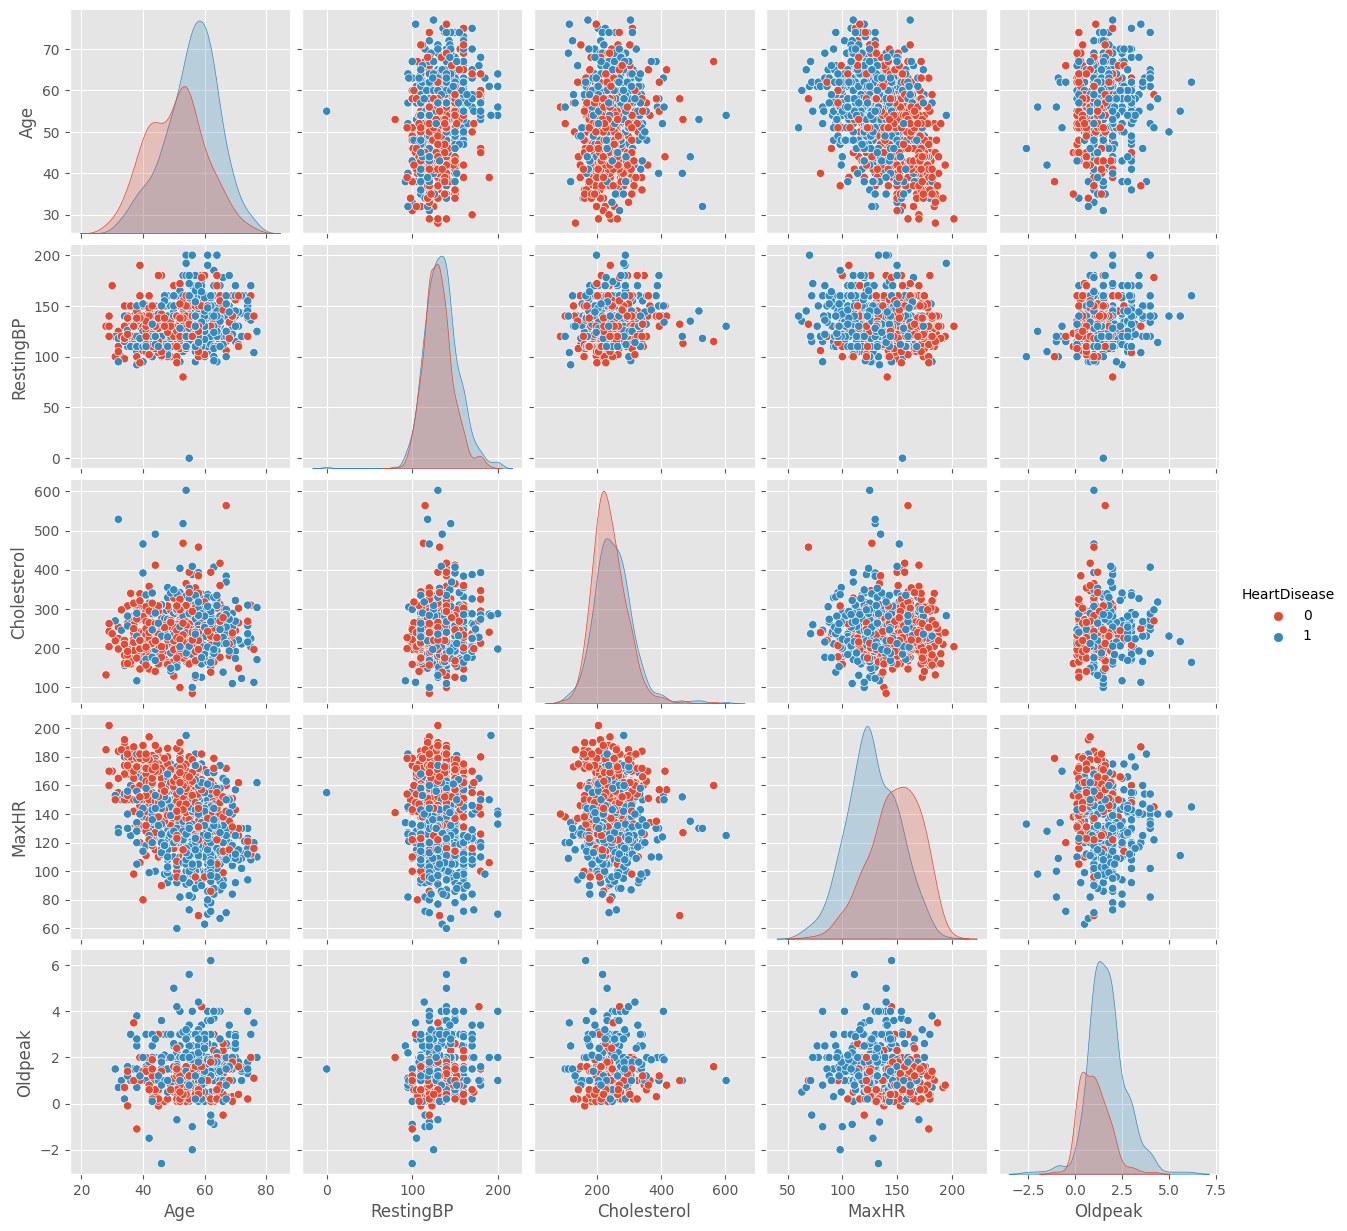

In [127]:
heart_1 = heart.drop("FastingBS", axis=1)
sns.pairplot(heart_1, hue="HeartDisease")

Graficamos las variables numéricas del dataset. En esta predicción unicamente se utilizan las variables numéricas para predecir le enfermedad cardiaca. Algunas variables categóricas son indudablemente relevantes para la predicción, pero no se implementaron por desconocimiento de su implementación.

Podemos observar las distribuciones de las variables categóricas con una gráfica "violin". Para observarlas todas podemos variar el índice de la variable "categorical".

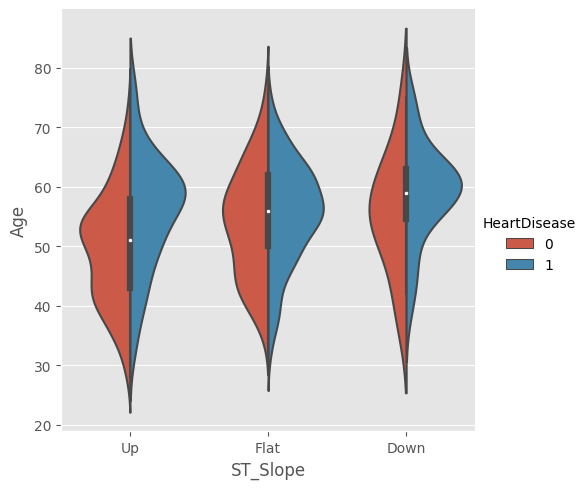

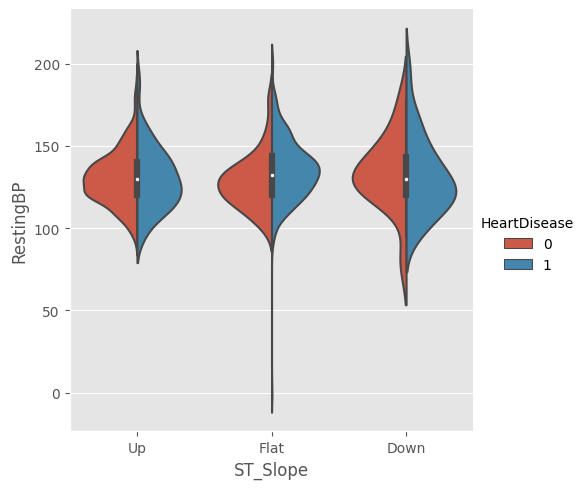

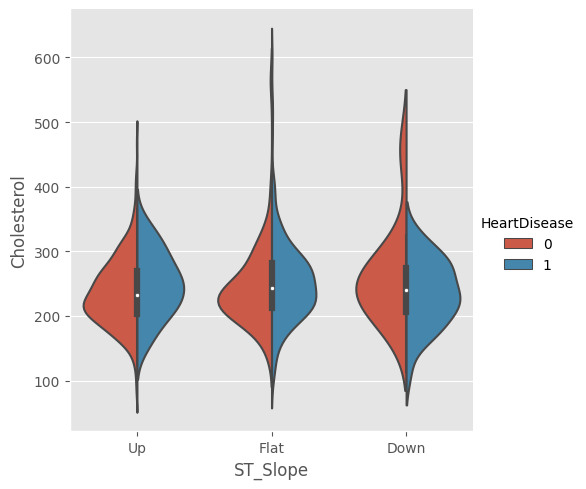

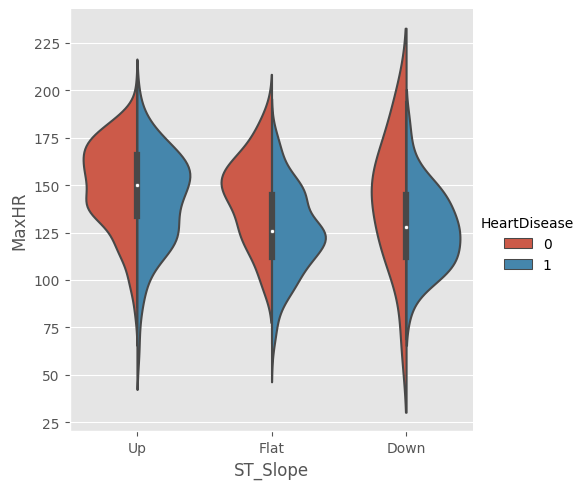

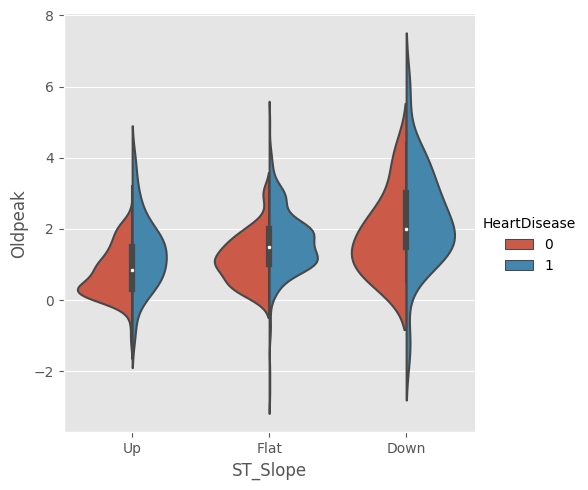

In [128]:
# categorical = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]
indice = 5
cat = categorical[indice]
for col in numericos:
  sns.catplot(data=heart, x=cat, y=col, hue="HeartDisease", kind="violin", split=True)

--------------
# Método

Para el modelo observamos que la predicción dada por el dataset es un valor booleano, verdadero representado con el número 1 y falso, representado con el número 0. Por esta razón se busca que el modelo pueda replicar las dos salidas únicamente. Se emplea un modelo de regresión logística, un modelo que graficamente se ve como una curva sigmoide y tiene la siguiente forma:

$$
y = \frac{1}{1+ e^{-X\theta}}
$$

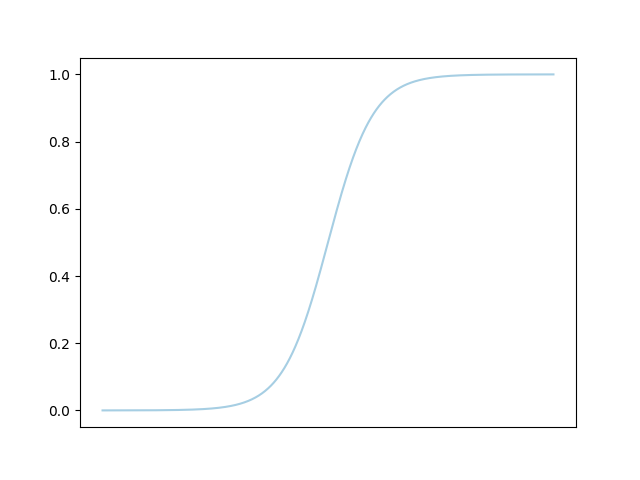


Donde $\theta$ son los parametros a ajustar y $X$ el conjunto de
mediciones que corresponde a cada columna de las variables numéricas (en orden). En este caso, la exponencial tiene la forma:
$$
e^{-X\theta} = e^{-(\theta_1 + \theta_2*X_1 + \theta_3*X_2+ \theta_4*X_3 + \theta_5*X_4 + \theta_6*X_5)}
$$


In [129]:
# función de modelo de regresión logística
def modelo(x, w):
  e, w_1 = w[0], w[1:]
  for x_n, w_n in zip(x, w_1):
    e += x_n * w_n
  y = 1 / (1 + np.exp(-1*e))
  return y

Se emplea un likelihood gaussiano y prior plano

In [130]:
#Likelihood
def Log_Likelihood(x, y, w, modelo):
  likelihood = -0.5 * np.sum((y - modelo(x, w))**2)
  return likelihood

#Prior Plano
def Log_Prior(w, rangos):
  flag = True
  for min, max, w in zip(rangos[0], rangos[1], w):
    if not (min <= w <= max):
      flag = False
  if flag:
    return 0
  else:
    return -np.inf

#Posterior
def Log_Posterior(x, y, w, modelo, rangos):
  logl = Log_Likelihood(x, y, w, modelo)
  logp = Log_Prior(w, rangos)

  posterior = logl + logp
  return posterior

Se crea una función para generar parametros dado una media y desviación estándar

In [131]:
def generar_parametros(w, std):
  parametros = []
  for mu, sigma in zip(w, std):
    w_nuevo = np.random.normal(mu, sigma)
    parametros.append(w_nuevo)
  return np.array(parametros)

Se define el método monte carlo metropoli

In [132]:
def Metropoli(x, y, iteraciones, modelo, w_inicial, rangos, std):
  reg_aceptadas, reg_rechazadas, reg_rechazadas_inf = [], [], []

  for i in range(iteraciones):
    w_propuesta = generar_parametros(w_inicial, std)

    posterior_inicial = Log_Posterior(x, y, w_inicial, modelo, rangos)
    posterior_propuesta = Log_Posterior(x, y, w_propuesta, modelo, rangos)

    if posterior_propuesta == -np.inf:
      reg_rechazadas_inf.append(w_propuesta)
      continue

    if posterior_propuesta > posterior_inicial:
      w_inicial = w_propuesta
      reg_aceptadas.append(w_propuesta)

    else:
      r = np.log(np.random.uniform())
      if (posterior_propuesta-posterior_inicial) > r:
        w_inicial = w_propuesta
        reg_aceptadas.append(w_propuesta)

      else:
        reg_rechazadas.append(w_propuesta)

  cociente_rechazados = np.shape(reg_rechazadas)[0]/iteraciones
  cociente_rechazados_inf = np.shape(reg_rechazadas_inf)[0]/iteraciones
  cociente_aceptacion = np.shape(reg_aceptadas)[0]/iteraciones
  cocientes = [cociente_aceptacion, cociente_rechazados, cociente_rechazados_inf]

  return np.array(reg_aceptadas), cocientes

Se definen las variables "X", las variables numéricas y la predicción "Y", la variable "heartdisease"del dataset.

In [133]:
heart = heart.fillna(0)
y = heart["HeartDisease"].values
x = heart[numericos].values.T

Se normalizan las variables X. Al evaluar en el modelo la exponencial tiende a 0 por los valores altos de las variables. Después de la normalización se obtienen resultados más normales.

In [134]:
x_norm = x
for i in range(x.shape[0]):
  x_norm[i] = (x[i] - np.mean(x[i])) / np.std(x[i])
x_norm

array([[-1.4331398 , -0.47848359, -1.75135854, ...,  0.37009972,
         0.37009972, -1.64528563],
       [ 0.41090889,  1.49175234, -0.12951283, ..., -0.12951283,
        -0.12951283,  0.30282455],
       [ 0.82507026, -0.17196105,  0.7701878 , ..., -0.62016778,
         0.34027522, -0.21769643],
       [ 1.38292822,  0.75415714, -1.52513802, ..., -0.85706875,
         1.4615246 ,  1.42222641],
       [-0.83243239,  0.10566353, -0.83243239, ...,  0.29328271,
        -0.83243239, -0.83243239]])

Se definen los parametros para utilizar el método monte carlo markov chain metropoli. La definición de estos valores afecta el desempeño de la función.

In [135]:
w = [1.4, 1.5, 0.4, -3, -2, 5.6]
std = [0.001, .001, .001, .001, .001, .01]

w = np.array(w)
std = np.array(std)

rangos_minimos = [-5, -5, -5, -5, -5, -5]
rangos_maximos = [5, 5, 5, 5, 5, 10]
rangos = [rangos_minimos, rangos_maximos]
iteraciones = 10000

Se aplica la función para obtener las cadenas y los cocientes de aceptación.

In [160]:
resultados, cocientes = Metropoli(x_norm, y, iteraciones, modelo, w, rangos, std)

In [161]:
print("Cocientes de aceptación: \n",
      "\nAceptación ", cocientes[0],
      "\nRechazo ", cocientes[1],
      "\nRechazo por infinito ", cocientes[2] )

Cocientes de aceptación: 
 
Aceptación  0.9947 
Rechazo  0.0053 
Rechazo por infinito  0.0


Al mostrar los coeficientes de aceptación notamos que se están aceptando el 99% de los pasos. Es un indicativo que el método pareciera no estar convergiendo. Una aceptación de ~(70%-80%) es un mejor indicativo. Este problema quita confianza a los resultados de este trabajo. Una posible solución es cambiar los parametros de la función metropoli (se mencionó que son importantes). Es posible mejorar la elección de parametros a partir de los resultados de una cadena y refinarlos iterativamente.

Se hace el burning de los valores de la cadena que no pertenecen a la convergencia. Se seleccionan la segunda mitad de los datos. Este paso no es muy relevante si la cadena no converge, pero mejora ligeramente los resultados.

In [162]:
n=-int(iteraciones*0.5)
resultados = resultados[n:]

Graficamos las cadenas. Como tenemos 6 parametros, se grafica un parametro seleccionado por el indice respecto a los demás. Debería poder graficarlos para obtener una visualización como el pairplot, pero no se implementó por el desconocimiento de su implementación.

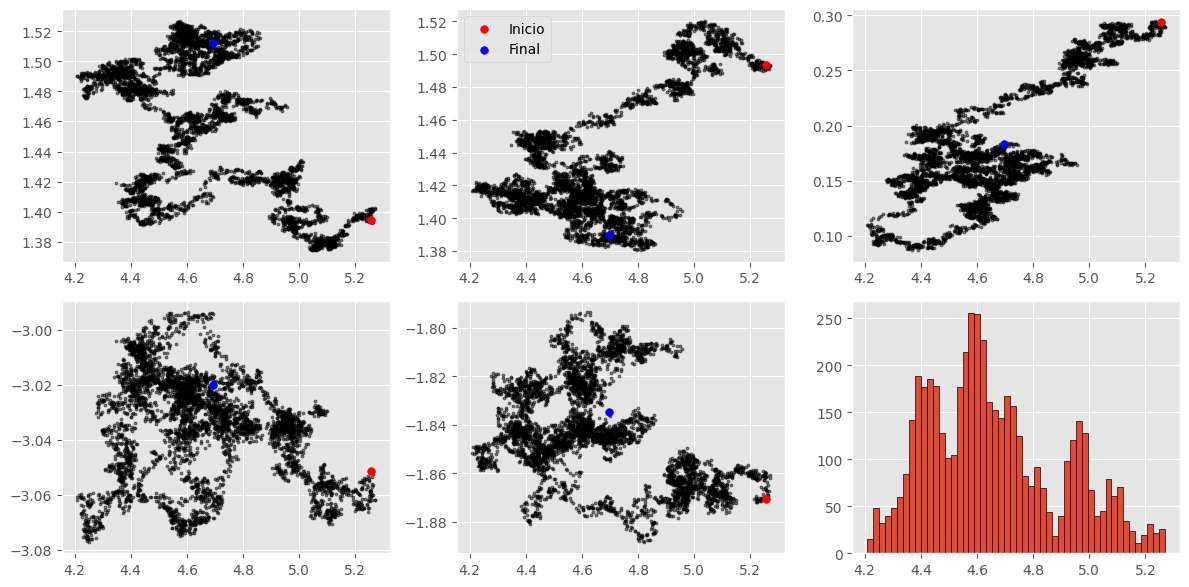

In [163]:
indice = 5
n = resultados.shape[1]
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
for f, g, h in zip(range(n), [0, 0, 0, 1, 1, 1], [0,1,2,0,1,2]):
  if f != indice:
    ax[g, h].scatter(resultados[:, indice], resultados[:,f], 5, alpha=0.5, color="black")
    ax[g, h].scatter(resultados[:, indice][0], resultados[:, f][0], 30, "red", alpha=1, label="Inicio")
    ax[g, h].scatter(resultados[:, indice][-1], resultados[:, f][-1], 30, "blue", alpha=1, label="Final")
  else:
    ax[g, h].hist(resultados[:,indice], bins=50, edgecolor='black')

ax[0, 1].legend()
plt.tight_layout()
plt.show()

Claramente no hay un convergencia al graficar las cadenas. Podremos verificar si de verdad hay convergencia utilizando el método de Gelman - Rubin.

Se grafica las 6 distribuciones obtenidas.

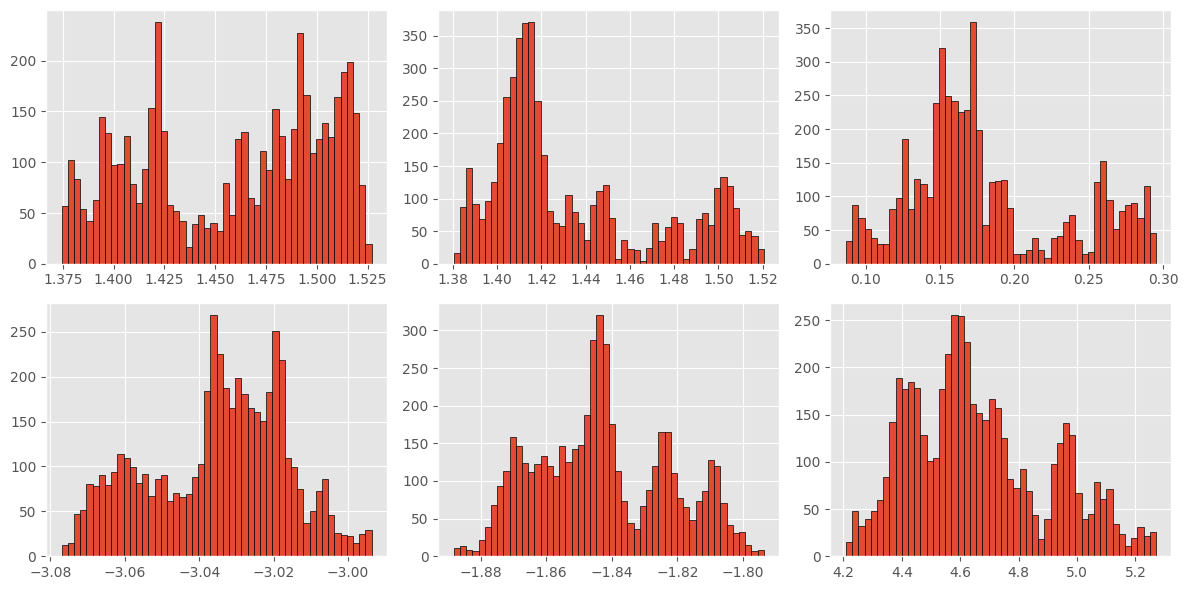

In [164]:
n = resultados.shape[1]
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
for i, g, h in zip(range(n), [0, 0, 0, 1, 1, 1], [0,1,2,0,1,2]):
  ax[g, h].hist(resultados[:,i], bins=50, edgecolor='black')

plt.tight_layout()
plt.show()

Obtenemos el ajuste de los parametros al seleccionar el valor más probable de la distribución creada de cada parametro.

In [165]:
parametros = []

for i in range(n):
  counts, bins = np.histogram(resultados[:, i], bins=20)
  max_value = (bins[np.argmax(counts)] + bins[np.argmax(counts)+1])/2
  parametros.append(max_value)

print("Parametros ajustados:", parametros)
parametros = np.array(parametros)

Parametros ajustados: [1.4926718462715627, 1.411946934232632, 0.1545275534181625, -3.0373909202872063, -1.8432804695961278, 4.6067226765299605]


Se verifica la obtención de los parametros múltiples veces dado los mismos argumentos de la función metropoli. A continuación los resultados.


1.   Parametros ajustados: [1.389, 1.457, 0.392, -3.002, -2.020, 5.699]
2.   Parametros ajustados: [1.325, 1.451, 0.354, -3.108, -2.106, 5.225]
3.  Parametros ajustados: [1.402, 1.372, 0.342, -3.131, -2.000, 5.945]
4.  Parametros ajustados: [1.444, 1.420, 0.422, -2.840, -2.099, 5.121]

5.  Parametros ajustados: [1.492, 1.411, 0.154, -3.037, -1.843, 4.606]







Se genera la prediccion de la enfermedad cardiaca. Para que los valores fueran solo 0 y 1 se redondean desde 0.5. Menor a 0.5 se convierte en 0 y mayor se convierte a 1.

In [142]:
y_prediccion = modelo(x, prediccion)
y_prediccion = np.round(y_prediccion)

Se muestra la cantidad de enfermos de los datos con la predicción.

Histograma de la varaible "HearDisease" original

<Axes: xlabel='HeartDisease', ylabel='Count'>

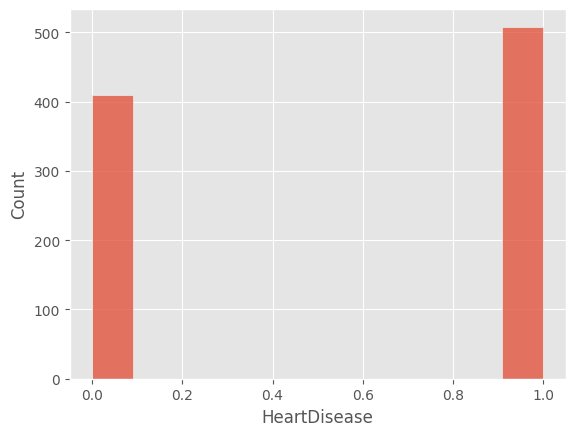

In [143]:
sns.histplot(data=heart, x="HeartDisease")

Histograma de la predicción variable "HeartDisease"

<Axes: xlabel='HeartDisease_prediction', ylabel='Count'>

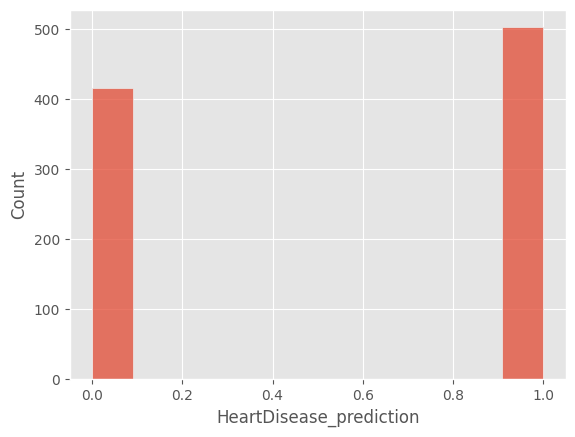

In [144]:
heart_2 = heart_1.drop("HeartDisease", axis=1)
heart_2["HeartDisease_prediction"] = y_prediccion

sns.histplot(data=heart_2, x="HeartDisease_prediction")

Sobreposición de ambas

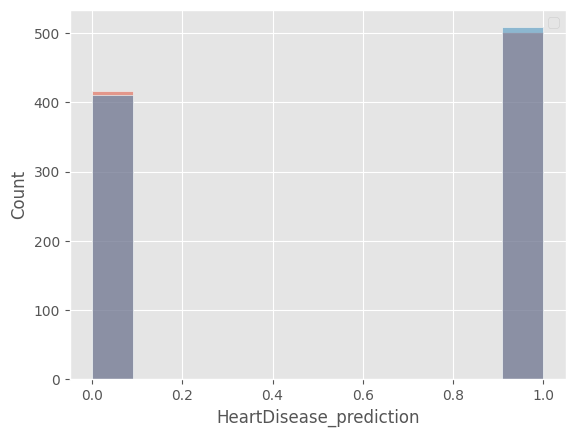

In [152]:
sns.histplot(data=heart_2, x="HeartDisease_prediction", alpha=0.5)
sns.histplot(data=heart, x="HeartDisease", alpha=0.5)
plt.legend()

In [146]:
print("Valores reales: ")
print(heart["HeartDisease"].value_counts())

print("\nValores predichos: ")
heart_2["HeartDisease_prediction"].value_counts()

Valores reales: 
1    508
0    410
Name: HeartDisease, dtype: int64

Valores predichos: 


1.0    502
0.0    416
Name: HeartDisease_prediction, dtype: int64

Se observa una predicción cercana a los valores originales. En la predicción hay menos enfermos. Es relevante comentar que no se separó el dataset en entrenamiento y validación. Ssin excusas, algo que se debió haber hecho, my bad. Por esto hay un sobreajuste. Se puede utilizar cross validation para separar el dataset.

Para finalizar, observamos cómo se comportan las graficas de las variables numéricas respecto con distinción entre los enfermos y no enfermos. Primero recordamos cómo son estas graficas originalmente.


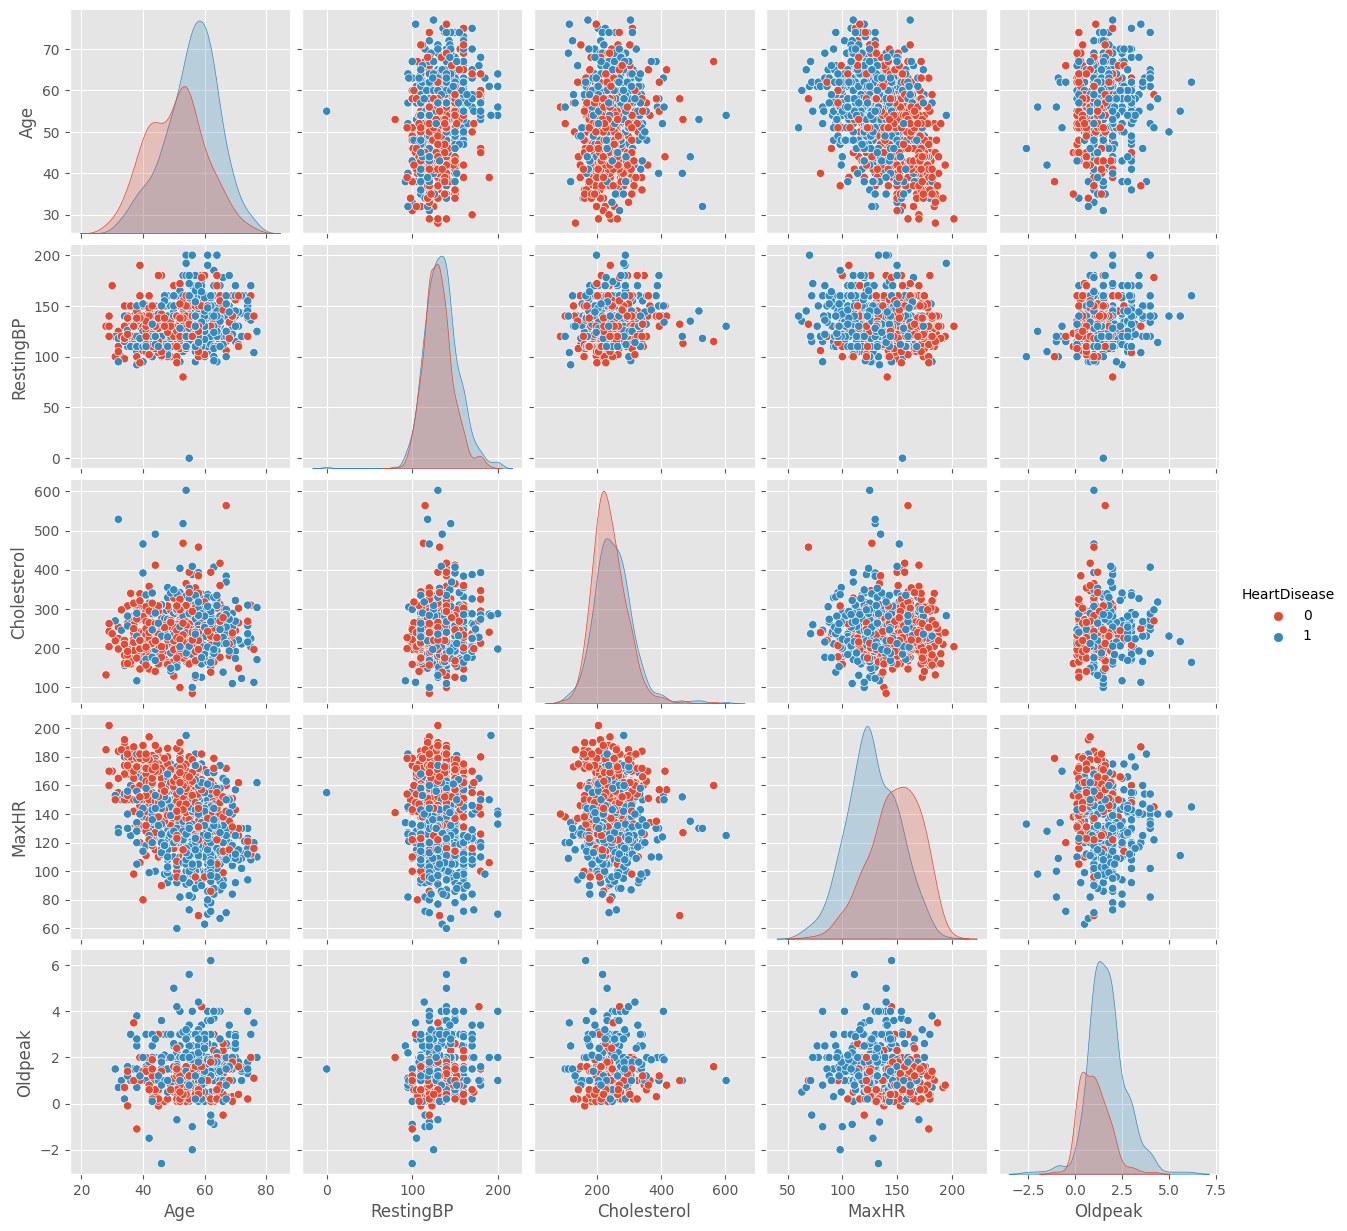

In [147]:
sns.pairplot(heart_1, hue="HeartDisease")

Se grafican utilzando las predicciones.

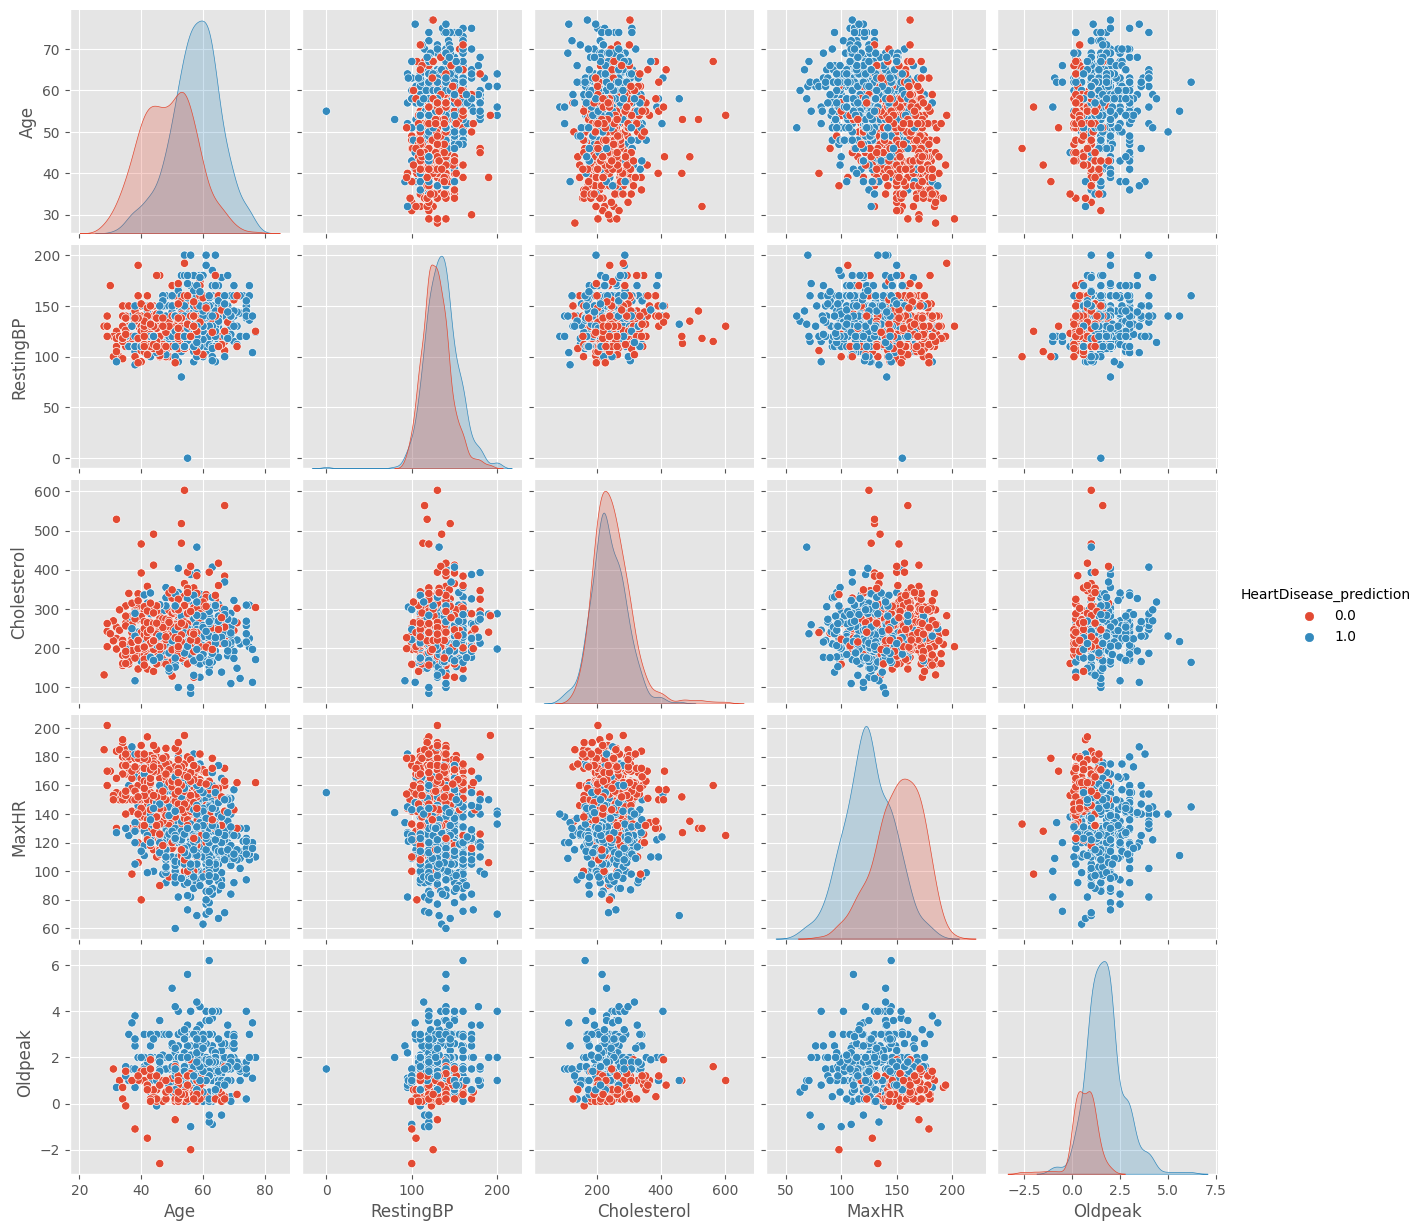

In [148]:
sns.pairplot(heart_2, hue="HeartDisease_prediction")

Hay un gran parecido. No podemos considerar que es una buena predicción por los problemas mencionados a lo largo del trabajo (sobreajuste, no convergencia o variación de los parametros del método metropoli). Se corregirá por amor al arte, pero no es el trabajo entregado hasta la fecha establecida.

------------------------------
# Convergencia

Acontinuación se aplica el método de Gelman - Rubin para verificar la convergencia de las cadenas.

In [149]:
def cadenas(no_cadenas, burning, x, y, iteraciones, modelo, rangos, std):
  m = no_cadenas
  n = burning
  ws = []
  for i in range(std.shape[0]):
    w_i = np.random.uniform(rangos[0][i], rangos[1][i])
    ws.append(w_i)
  ws =np.array(ws)

  cadenas = []
  for i in range(m):
    w = generar_parametros(ws, std)
    cad, _ = Metropoli(x, y, iteraciones, modelo, w, rangos, std)
    cad = cad[-n:]
    cadenas.append(cad)
  cadenas = np.array(cadenas)
  return cadenas

def gelman_rubin(m, n, cadenas):
  Xi = np.zeros((m, cadenas.shape[-1]))
  for i in range(m):
    for j in range(cadenas.shape[-1]):
      promedios = 1/n * np.sum(cadenas[i, :, j])
      Xi[i, j] = promedios


  si = np.zeros((m, cadenas.shape[-1]))
  for i in range(m):
    for j in range(cadenas.shape[-1]):
      varianza = 1/(n-1) * np.sum((cadenas[i, :, j] - Xi[i, j])**2)
      si[i, j] = varianza
  np.sqrt(si)

  W = np.zeros((cadenas.shape[-1]))
  for i in range(cadenas.shape[-1]):
    mean = 1/m * np.sum(si[:,i])
    W[i] = mean

  mu = np.zeros((cadenas.shape[-1]))
  for i in range(cadenas.shape[-1]):
    mean = 1/m * np.sum(Xi[:,i])
    mu[i] = mean

  Bn = np.zeros((cadenas.shape[-1]))
  for i in range((cadenas.shape[-1])):
    bn = 1/(m-1) * np.sum((Xi[:,i]-mu[i])**2)
    Bn[i] = bn

  sigma = np.zeros((cadenas.shape[-1]))
  sigma = (n-1)/n * W + Bn

  R = np.sqrt(sigma/W)
  return R

def convergencia(no_cadenas, burning, x, y, iteraciones, modelo, rangos, std):
  cad = cadenas(no_cadenas, burning, x, y, iteraciones, modelo, rangos, std)
  R = gelman_rubin(no_cadenas, burning, cad)
  print("R: ", R)
  return R

In [150]:
cad = convergencia(5, 5000, x_norm, y, iteraciones, modelo, rangos, std)

R:  [1.99330756 3.37037237 3.00140938 3.17211185 2.40756282 1.04723781]


Se dice que hay convergencia de las cadenas si el valor R es 1.
Se verifica la convergia múltiples veces. A continuación los resultados.


1.   R:  [3.17219418 3.18418363 2.34358255 2.18705879 1.70925402 1.04721072]

2.   R:  [3.21455351 2.58776299 2.40529772 1.575285   2.18606942 1.99821625]

3.  R:  [2.47092248 3.47630348 3.27668451 3.14050577 2.51127859 1.12891925]

4.  R:  [2.65246295 4.36295945 3.29370694 2.94584647 3.18821256 1.83050067]

5.  R:  [1.14941862 2.06541279 2.12927212 3.4037518  4.21936894 3.39122486]




A veces el valor de R se acerca a 1 y a veces se aleja. Si convergieran adecuadamente este valor debría ser cercano a 1 en todas las ocasiones.